# QUANTITATIVE TRADING STRATEGIES - HW 1

## Futures Spread Dynamics

**Name**: Adriana Mata

**Date**: 14/01/2024

**Table of Contents:**

1. Introduction
2. Data Manipulation

    * 2.1. Data Extraction
    * 2.2. Data Handling
    * 2.3. Data Cleaning
    * 2.4. Data Computation
    * 2.5. Data Validation

.

3. Individual Spread Analysis

    * 3.1. Time Series Analysis
    * 3.2. Statistical Analysis
    * 3.3. Volatility Analysis
    * 3.4. Risk Metrics Analysis
    * 3.5. Technical Analysis
    
.

4. Comparative Analysis

    * 4.1. Frequency Analysis
    * 4.2. Correlation Matrix
    * 4.3. Deviation Correlation Matrix
    * 4.4. Cross-Correlation

# 1. Introduction 

This first project in the Quantitative Trading Strategies class focuses on the ability to interpret financial data provided by NASDAQ Quandl. The project aims to provide hands-on experience in extracting, processing, and analyzing data, which are fundamental skills in quantitative finance.

The analysis will be based on two specific pairs of futures spreads in order to gain a deeper understanding of the underlying patterns and behaviors in these financial instruments, the chosen pairs are CBT FV FV vs. CBT US US and CBT TU TU  vs. CBT US US.

The project is divided into different sections, the first part focuses on data extraction, manipulation and processing. Once the data is clean and ready to use, each spread will be analyzed independently to examine its behavior. Finally, a comparative analysis will be computed to understand the relationship and dynamics of both spreads. 

By the end of the project, we expect to have a deeper understanding of the behavior of these specific futures spreads and how they interact with each other.


# 2. Data Manipulation

## 2.1. Data Extraction

The data extraction process involves retrieving financial data from NASDAQ Quandl. This extraction was done using the University of Chicago email account, which provides students with access to a wide variety of data sources and datasets for analysis.

Before starting the data extraction, it is necessary to ensure that the required libraries are imported into the Jupyter Notebook file. These libraries, such as Pandas, NumPy, Matplotlib, among others, will be very useful to reduce the length of the code and make tasks more efficient.


In [202]:
import os
import datetime
import quandl

import pandas as pd
import numpy as np
import scipy as sp
from scipy.fft import fft, fftfreq
import plotnine as p9

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import Normalize

import scipy.stats as stats
from scipy.stats import norm

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint

import warnings

import config

warnings.filterwarnings("ignore")

The ``grab_quandl_table`` function is responsible for handling the download of data tables from Quandl. This function has been designed to avoid downloading the same data repeatedly. Hence, it will only grab new data once per day; otherwise, it will use the data from the file cache.

For this function to work, we need to specify the Quandl table path, the path to the directory where we want to store the downloaded data, and the private API Key, which is provided when you create your account on Quandl. If the download is successful and there's no date override, the function creates a symlink to the downloaded file.


In [203]:
path = os.getcwd()

def grab_quandl_table(table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(path, "quandl_data_table_downloads") # Change this to your own directory
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=config.QUANDL_API_KEY, **kwargs # Private API key
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )



This function wraps around the previously defined `grab_quandl_table` to fetch and return a Pandas DataFrame. It reads the downloaded data file into a DataFrame and returns it for further analysis.

In this case, all data regarding ‘AR/IVM’ has been downloaded. This data contains multiple exchange, futures, and options codes, as well as multiple expiration numbers. This data will be sorted and cleaned in the upcoming steps, as we are only focusing on two specific pairs of futures.

In [204]:
t_ivm = fetch_quandl_table('AR/IVM', avoid_download=False)
t_ivm.head()

Download finished: 290238259 bytes
Removing old symlink
Creating symlink: /Users/adriana/Jupyter_Files/FINM33150_Quantitative_Trading_Strategies/Homework/quandl_data_table_downloads/AR/IVM_20240115.zip -> /Users/adriana/Jupyter_Files/FINM33150_Quantitative_Trading_Strategies/Homework/quandl_data_table_downloads/AR/IVM_latest.zip


,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,CBT,BO,BO,V2024,2023-07-27,58.040000,0.303074,-0.004934,NaN,-0.005185,...,-0.013514,-0.210955,0.274140,1.697856,-1.023394,-4.179139,-0.549587,0.444217,421.24,445.0
1,ICE,KC,KC,H2026,2023-10-02,158.550000,0.288991,0.015911,NaN,0.000022,...,0.025836,-0.177754,0.101765,1.435220,-0.445698,-2.374568,-0.684043,0.532352,863.15,899.0
2,NYM,NG,NG,F2029,2023-07-27,4.703000,0.334631,NaN,NaN,NaN,...,0.159299,0.133878,-1.147995,-1.006677,1.590494,1.477700,-0.737270,0.754384,1979.00,1980.0
3,NYX,C,C,U2025,2023-10-02,2666.000000,0.231555,NaN,NaN,NaN,...,0.120610,-2.579713,1.159924,594.907525,-91.601577,-52350.067091,-0.074339,0.075473,696.80,714.0
4,CBT,BO,BO,1M,2023-07-27,67.346897,0.352890,-0.002929,-0.005976,0.002417,...,-0.024721,0.420288,-0.644045,23.556375,14.352899,-214.004951,-0.222364,0.238453,31.00,31.0


## 2.2. Data Handling

After fetching the data, it's essential to make a copy of the DataFrame for analysis to avoid modifying the original dataset directly. This is done using `data = t_ivm.copy()`. Working with a copy ensures that the raw data remains intact and can be referenced or re-used without the risk of data corruption or unintended changes.

After the data extraction phase, the data is readily accessible and in a suitable format for the subsequent steps of the project, which include data cleaning and validation.

In [206]:
data = t_ivm.copy()

# len(data) # As reference the data has 4903145 rows

## 2.3. Data Cleaning

In this section of the project, the data will be sorted and cleaned according to the specifications provided in the **'HW1_FuturesSpreadDataCharacterization.pdf'** document.

Initially, the future pairs will be defined, along with the coefficients that will be applied to the futures X and Z, respectively. These futures are traded on the Chicago Board of Trade (CBT) and are described as follows:

* First Pair (W, X):

    * W: CBT FV FV (5-Year Treasury Note Futures)
    * X: CBT US US (30-Year Treasury Bond Futures)
    
.

* Second Pair (Y, Z):

    * Y: CBT TU TU (2-Year Treasury Note Futures)
    * Z: CBT US US (30-Year Treasury Bond Futures, same as in the first pair)


In [207]:
# First Pair W, X
W = 'CBT_FV_FV'
X = 'CBT_US_US'

coefficient1 = 0.7595

# Second Pair Y,Z
Y = 'CBT_TU_TU'
Z = 'CBT_US_US'

coefficient2 = 0.6873

This function, `generate_letter_year_combinations`, filters the data based on specific expiration codes. It generates a list of combinations using quarterly codes (H, M, U, Z) for a specified year range, in this case, from 2020 to 2023. The function returns a list of strings representing the expiration codes (e.g., 'H2020', 'M2020', etc.) that is then used to filter the original DataFrame, `data`, to include only those rows where the 'expiration' column matches any of the generated combinations.

As a result of this filtering, the dataset has been significantly reduced by 91.69%, decreasing the length of the DataFrame from 4,903,145 to 407,398 rows.

In [208]:
def generate_letter_year_combinations(letters, start_year, end_year):
    """ 
    Generate letter year combinations for a given list of letters and years
    Inputs:
        letters (list): list of letters
        start_year (int): start year
        end_year (int): end year
    
    Outputs:
        list: list of letter year combinations
    """
    combinations = []
    for letter in letters:
        for year in range(start_year, end_year + 1):
            combination = f"{letter}{year}"
            combinations.append(combination)
    return combinations

# Usage
letters = ["H", "M", "U", "Z"] 
start_year = 2020
end_year = 2023
combinations = generate_letter_year_combinations(letters, start_year, end_year)
print(combinations)

# Filter the DataFrame by specific expiration dates
filtered_data = data[data['expiration'].isin(combinations)]
filtered_data.head()

# len(filtered_data) # As reference the data has 407398 rows (4903145) 
# (len(data) - len(filtered_data)) / len(data) # 0.9169

['H2020', 'H2021', 'H2022', 'H2023', 'M2020', 'M2021', 'M2022', 'M2023', 'U2020', 'U2021', 'U2022', 'U2023', 'Z2020', 'Z2021', 'Z2022', 'Z2023']


,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
16,CBT,BO,BO,U2023,2023-07-27,65.820,0.353609,-0.003242,-0.006429,0.002404,...,-0.027875,0.440011,-0.608474,26.505782,15.366993,-253.462412,-0.216632,0.231917,29.24,49.0
19,CBT,BO,BO,Z2023,2023-07-27,62.070,0.318144,0.006360,0.007739,0.002287,...,0.028071,0.105257,-0.564205,2.506645,2.372051,-8.564727,-0.378759,0.441280,120.24,140.0
36,CBT,C,C,U2023,2023-07-27,533.250,0.326398,0.033522,0.066092,0.005193,...,0.261284,0.754739,-2.603799,21.114772,-8.954084,-61.880326,-0.169743,0.257701,29.24,49.0
40,CBT,C,C,Z2023,2023-07-27,542.250,0.289085,0.014845,0.036829,0.002339,...,0.060818,0.052168,0.113823,3.572355,-0.951841,-9.999818,-0.304263,0.449509,120.24,140.0
69,CBT,FF,FF,U2023,2023-07-27,94.655,0.174035,-0.008502,-0.016772,-0.000329,...,0.091898,-0.484008,-2.977015,102.208976,238.279221,-4949.221135,-0.125961,0.144685,67.08,67.0


After filtering the data for specific expiration dates, the next step involves isolating data for each of the defined futures pairs. This isolation is achieved through conditional filtering based on the exchange code, futures code, and option code. The futures have been assigned to each student based on the last two digits of their student ID.

This step separates the data into distinct DataFrames for each future in our pairs, allowing for individualized analysis and comparison. It ensures that the analysis is focused on the relevant and specific segments of the dataset corresponding to our chosen futures.

In [209]:
W_data = filtered_data[(filtered_data['exchange_code'] == 'CBT') & (filtered_data['futures_code'] == 'FV') & (filtered_data['option_code'] == 'FV')]
X_data = filtered_data[(filtered_data['exchange_code'] == 'CBT') & (filtered_data['futures_code'] == 'US') & (filtered_data['option_code'] == 'US')]
Y_data = filtered_data[(filtered_data['exchange_code'] == 'CBT') & (filtered_data['futures_code'] == 'TU') & (filtered_data['option_code'] == 'TU')]
Z_data = filtered_data[(filtered_data['exchange_code'] == 'CBT') & (filtered_data['futures_code'] == 'US') & (filtered_data['option_code'] == 'US')]

The `filter_by_smallest_days_termination` function is designed to filter rows based on the 'days_termination' column, which represents the number of days until a contract expires. The function targets contracts with the smallest available number of days to expiration, greater than 30 days. Initially, it excludes all rows where 'days_termination' is 30 days or less. Subsequently, within each unique date, the function selects the row with the smallest 'days_termination' value. The output of this function is a new DataFrame that provides a daily view of the contract closest to expiration. 

Then, the script iterates over a dictionary containing data for each specific future and applies the `filter_by_smallest_days_termination` function to each one.

In [210]:
def filter_by_smallest_days_termination(df):
    """ 
    Filter the DataFrame by the smallest days_termination for each date
    Inputs:
        df (pd.DataFrame): DataFrame to filter
    
    Outputs:
        pd.DataFrame: filtered DataFrame
    """
    
    df['date'] = pd.to_datetime(df['date'])

    # Filter out rows where days_termination is 30 or less
    filtered_df = df[df['days_termination'] > 30]

    # Group by date and keep the row with the smallest days_termination for each date
    return filtered_df.groupby('date').apply(lambda x: x.nsmallest(1, 'days_termination')).reset_index(drop=True)

# Usage
# List of DataFrames
dataframes = [W_data, X_data, Y_data, Z_data]

# Dictionary to hold the filtered DataFrames
filtered_dataframes = {}

for i, df in enumerate(dataframes):
    # Ensure 'date' is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Apply the function and get the filtered results
    filtered_df = df.groupby('date').apply(filter_by_smallest_days_termination).reset_index(drop=True)

    # Store the filtered DataFrame in the dictionary
    filtered_dataframes[f'filtered_{chr(87+i)}_data'] = filtered_df


The `filter_by_date_range` function is designed to filter rows based on a specific date range, from '2020-12-03' to '2023-08-31'. This function helps narrowing down data to a targeted time period. The function processes the filtered data along with the defined time range and returns a new DataFrame encompassing only the rows that are within the specified date range.

Subsequently, the script executes two distinct loops. The first loop iterates over the `filtered_dataframes` dictionary, applying the `filter_by_date_range` function to each key, this process filters each dataframe based on the defined date range.  The second loop iterates over the `date_range_filtered_dataframes`` dictonary to extract the four dataframes that that encapsulate all the filtered data, these dataframes follow a specific naming convention to ensure the correct organization for further analysis. 

In [211]:
def filter_by_date_range(df, start_date, end_date):
    """
    Filters a DataFrame based on a given date range.

    Inputs:
        df (pf.DataFrame): The DataFrame to be filtered.
        start_date (str): The start date in 'YYYY-MM-DD' format.
        end_date (str): The end date in 'YYYY-MM-DD' format.

    Outputs:
        pd.DataFrame: A filtered DataFrame containing rows within the given date range.
    """
    # Ensure 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Filter the DataFrame
    filtered_df = df[(df['date'] >= pd.to_datetime(start_date)) & (df['date'] <= pd.to_datetime(end_date))]

    return filtered_df

# Usage
start_date = '2020-12-03'
end_date = '2023-08-31'

# Dictionary to hold the date range filtered DataFrames
date_range_filtered_dataframes = {}

for key, df in filtered_dataframes.items():
    # Apply the date range filter
    date_range_filtered_df = filter_by_date_range(df, start_date, end_date)

    # Store the date range filtered DataFrame in the new dictionary
    date_range_filtered_dataframes[key] = date_range_filtered_df

# Loop through the date_range_filtered_dataframes dictionary
for key, df in date_range_filtered_dataframes.items():
    # Create a dynamic variable name based on the key
    final_var_name = key.replace('filtered_', '') + '_final'

    # Assign the DataFrame to the dynamically created variable name
    globals()[final_var_name] = df


## 2.4. Data Computation

Having completed the essential data filtering steps, we can now begin the calculation phase of our project. Firstly, the coefficients `coefficient1` and `coefficient2`, which were determined earlier in the project, will be multiplied with the data of specific futures. In this case, `coefficient1` will be applied to the `X_data_final` DataFrame and `coefficient2` to the `Z_data_final` DataFrame.

In [212]:
X_data_final['futures'] = X_data_final['futures'] * coefficient1
Z_data_final['futures'] = Z_data_final['futures'] * coefficient2

Then, we are extracting data for each future by selecting only the essential columns required for analysis. Specifically, we are extracting the 'date' and 'futures' columns from each DataFrame (X_data_final, Z_data_final, Y_data_final, W_data_final). The 'futures' column contains the futures price, which is important for computing the spread.

After selecting these columns, we set the 'date' column as the index for each DataFrame. Setting the 'date' column as the index facilitates time-series analysis, as the index now directly represents the chronological order of the data. 

In [213]:
X_future = X_data_final[['date', 'futures']]
X_future.set_index('date', inplace=True)

Z_future = Z_data_final[['date', 'futures']]
Z_future.set_index('date', inplace=True)

Y_future = Y_data_final[['date', 'futures']]
Y_future.set_index('date', inplace=True)

W_future = W_data_final[['date', 'futures']]
W_future.set_index('date', inplace=True)


The final computation in the project involves calculating the spread between the futures, as per the formula provided in the **'HW1_FuturesSpreadDataCharacterization.pdf'** document. The spread is a crucial financial metric that represents the difference in value between two futures contracts. 

This calculation is defined as follows:

$$s_1 = X_t - W_t$$
$$s_2 = Z_t - Y_t$$

The computed spread will provide insights on the relative movements and relationships between the pairs of futures contracts.

In [214]:
# Compute the spreads
s1 = (X_future['futures'] - W_future['futures']).to_frame(name='Futures Spread')
s1.index = pd.to_datetime(s1.index)
s2 = (Z_future['futures'] - Y_future['futures']).to_frame(name='Futures Spread')
s2.index = pd.to_datetime(s2.index)

s1.head()

,Futures Spread
date,
2020-12-03,5.478250
2020-12-04,4.638547
2020-12-07,5.139047
2020-12-08,5.534719
2020-12-09,5.177516


This step is designed to remove any NaN values from the DataFrame, ensuring the reliability of the analysis we are about to conduct.

In [215]:
s1.isna().sum().to_frame().rename(columns={0: 'Number of NaN'})
s1.dropna(subset=['Futures Spread'], inplace=True)

s2.isna().sum().to_frame().rename(columns={0: 'Number of NaN'})
s2.dropna(subset=['Futures Spread'], inplace=True)

## 2.5. Data Validation

The final step in our project involves validating the computed data against the values provided in the accompanying PDF file. We will compare the calculated spreads (s1 and s2) and with the values specified in the PDF, if the data matches means that all the filters have been applied correctly, otherwise if any discrepancies are found we will need to re-examining the formulas used anf the data filtering process.  

In [217]:
v1, v2, v3 = s1.loc['2021-11-19'].round(6).values[0], s1.loc['2021-11-24'].round(6).values[0], s1.loc['2021-11-26'].round(6).values[0]
v4, v5, v6 = s2.loc['2021-11-18'].round(6).values[0], s2.loc['2021-11-24'].round(6).values[0], s2.loc['2021-11-26'].round(6).values[0]

# Creating tables for s1 and s2 data
s1_data = {
    "Date": ['2021-11-19', '2021-11-24', '2021-11-26'],
    "Computed Value": [v1, v2, v3],
    "Provided Value": [1.271594, -0.658906, 1.274656],
    "Is Equal": [v1==1.271594, v2==-0.658906, v3==1.274656]
}
s1_table = pd.DataFrame(s1_data,index=[1,2,3])

s2_data = {
    "Date": ['2021-11-18', '2021-11-24', '2021-11-26'],
    "Computed Value": [v4, v5, v6],
    "Provided Value": [0.968594, -0.584031, 1.471644],
    "Is Equal": [v4==0.968594, v5==-0.584031, v6==1.471644]
}
s2_table = pd.DataFrame(s2_data,index=[4,5,6])

s1_table



,Date,Computed Value,Provided Value,Is Equal
1,2021-11-19,1.271594,1.271594,True
2,2021-11-24,-0.658906,-0.658906,True
3,2021-11-26,1.274656,1.274656,True


In [218]:
s2_table

,Date,Computed Value,Provided Value,Is Equal
4,2021-11-18,0.968594,0.968594,True
5,2021-11-24,-0.584031,-0.584031,True
6,2021-11-26,1.471644,1.471644,True


As can be seen, all the data matches with the data provided in the PDF, indicating that the data we are working with is correct. This confirmation allows us to proceed with both the individual and combined analyses.

# 3. Individual Spread Analysis

In the Individual Spread Analysis section of our project, we concentrate on examining each futures spread separately. This in-depth analysis is intended to explain the distinct behavior and characteristics of each spread. The analysis will employ a variety of techniques each with a specific purpose.


## 3.1. Time Series Analysis

In this phase of the project, we will develop a time series analysis to identify long-term trends in the spread and other anomalies in the data over time. 

The function `plot_spread_over_time_subplots` is designed to plot the spread data over time for the two dataframes. This visualization allows us to observe and compare the behavior of each spread, facilitating a comprehensive understanding of their dynamics.

The function `find_spread_extremes_with_dates` is designed to find the largest and smallest spread in a dataFrame and when these spreads happen. This table allows us to find the identify the most significant divergences and convergences between the futures pairs over a given period.

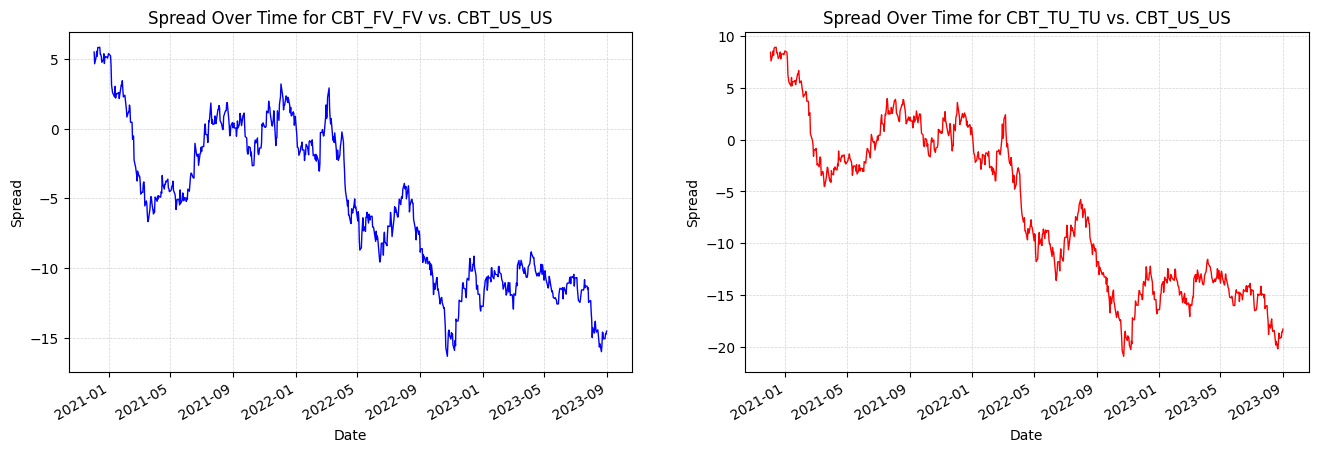

In [219]:
def plot_spread_over_time_subplots(df1, df2, column_name, titles):
    """
    Plots the specified column of two DataFrames over time in subplots.

    Inputs:
        df1, df2 (pd.DataFrame): DataFrames containing the data to plot.
        column_name (str): Name of the column to plot.
        titles (tuple): Titles of the plots.
    """
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    # Plot for df1
    df1[column_name].plot(ax=axs[0], kind='line', color='blue', linewidth=1)
    axs[0].set_title(titles[0])
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Spread')
    axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

    # Plot for df2
    df2[column_name].plot(ax=axs[1], kind='line', color='red',linewidth=1)
    axs[1].set_title(titles[1])
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Spread')
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

    plt.show()


def find_spread_extremes_with_dates(df, index_name, spread_column='Futures Spread'):
    """
    Find the largest and smallest spread in a DataFrame along with the dates when these extremes occurred.

    Inputs:
        df (pd.DataFrame): DataFrame containing the spread data with date as the index.
        spread_column (str): Name of the column in the DataFrame that contains the spread data.

    Outputs:
        pd.DataFrame: A DataFrame with the largest and smallest spread and the corresponding dates.
    """

    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)
    
    # Find the row with the maximum spread value
    max_spread = df[spread_column].max()
    max_spread_date = df[df[spread_column] == max_spread].index[0].strftime('%Y-%m-%d')
    
    # Find the row with the minimum spread value
    min_spread = df[spread_column].min()
    min_spread_date = df[df[spread_column] == min_spread].index[0].strftime('%Y-%m-%d')
    
    extremes_data = {
        'Max Spread': [max_spread],
        'Max Spread Date': [max_spread_date],
        'Min Spread': [min_spread],
        'Min Spread Date': [min_spread_date]
    }
    
    extremes_df = pd.DataFrame(extremes_data, index=[index_name])
    
    return extremes_df


# Plot the spreads over time
plot_spread_over_time_subplots(s1, s2, 'Futures Spread', (f'Spread Over Time for {W} vs. {X}', f'Spread Over Time for {Y} vs. {Z}'))

Both plots exhibit a downward trend over the observed time frame. The first plot presents the spread of **CBT_FV_FV vs. CBT_US_US**, where the maximum spread of 5.82 was reached on 2020-12-14, and the minimum spread of -16.31 occurred on 2022-10-24. A parallel trend is observed in the second plot, which shows the spread of **CBT_TU_TU vs. CBT_US_US**; here, the maximum spread of 8.90 was also reached on 2020-12-14, and the minimum spread of -20.89 occurred on 2022-10-24, indicating a larger range of movement.

It is not surprising that both plots reached their respective maximum and minimum spreads on the same dates, as they are traded within the same market and are subject to the same market stresses. The correlation in these movements underscores the interconnectedness of different financial instruments and highlights the impact of broader market events on various futures contracts.

Between 2020 and 2023, the bond markets experienced significant events that heavily influenced their dynamics. In 2022, bond markets experienced one of the sharpest sell-offs on record due to persistently high inflation and a series of interest rate hikes by central banks globally. This led to government bond yields reaching their highest levels in over a decade. The aggressive tightening in monetary policy was a reaction to combat inflation, which was further exacerbated by Russia’s invasion of Ukraine, causing a spike in energy and food prices and additional strain on emerging market economies.

Specially, in October 2022, the bond market experienced significant turmoil, recording one of its worst performances in history due to the Federal Reserve's aggressive interest rate hikes aimed at curbing soaring inflation. The rapid increase in rates, a response to persistent inflationary pressures, led to a decrease in bond prices as the cost of borrowing rose across the economy.

However, as we entered 2023, there was a sentiment that bond investors were at a better starting point with more attractive yields as inflation began to ease, offering potential for central banks to slow the pace of rate hikes.

In [220]:
# Find the largest and smallest spreads for each DataFrame
s1_extremes = find_spread_extremes_with_dates(s1, f'{W} vs. {X}', spread_column='Futures Spread')
s2_extremes = find_spread_extremes_with_dates(s2, f'{Y} vs. {Z}', spread_column='Futures Spread')

# Combine the results into a single table
extremes_table = pd.concat([s1_extremes, s2_extremes])
extremes_table


,Max Spread,Max Spread Date,Min Spread,Min Spread Date
CBT_FV_FV vs. CBT_US_US,5.821906,2020-12-14,-16.305719,2022-10-24
CBT_TU_TU vs. CBT_US_US,8.903544,2020-12-14,-20.886944,2022-10-24


This table depicts the largest and smallest spreads for each DataFrame, numbers that have been discussed in conjunction with the previous Time Series plots.

## 3.2. Statistical Analysis

In the Statistical Analysis phase of our project, we will focus on understanding the distributional properties of the spread data. This quantitative analysis forms the backbone of our project, enabling us to interpret the data accurately and make informed conclusions about the behavior and trends. 

The `display_descriptive_statistics` function is designed to calculate a set of descriptive statistics for a specified column within a given DataFrame. These statistics include key measures such as mean, median, standard deviation, variance, minimum and maximum values, quantiles (25%, 50%, 75%), interquartile range, skewness, and kurtosis. Each of these measures provides valuable insights into the distribution and characteristics of the data.

For our analysis, this function is applied to the 'Futures Spread' column of two separate DataFrames, `s1` and `s2`, representing different futures spreads. The function is called with specific index names corresponding to each futures pair. This results in two DataFrames, `s1_stats` and `s2_stats`, each containing the descriptive statistics for their respective spreads.

In [221]:
def display_descriptive_statistics(df, column_name, index_name):
    """
    Computes and returns a DataFrame containing a comprehensive set of descriptive statistics
    for a specified column in a DataFrame.

    Inputs:
        df (pd.DataFrame): DataFrame containing the data.
        column_name (str): Name of the column for which statistics are calculated.
        index_name (str): Name of the index for the resulting DataFrame.

    Outputs:
        pd.DataFrame: A DataFrame containing the descriptive statistics.
    """
    statistics = {
        "Mean": df[column_name].mean(),
        "Median": df[column_name].median(),
        "Standard Deviation": df[column_name].std(),
        "Variance": df[column_name].var(),
        "Minimum": df[column_name].min(),
        "Maximum": df[column_name].max(),
        "25% Quantile": df[column_name].quantile(0.25),
        "50% Quantile": df[column_name].quantile(0.50),
        "75% Quantile": df[column_name].quantile(0.75),
        "Interquartile Range": df[column_name].quantile(0.75) - df[column_name].quantile(0.25),
        "Skewness": df[column_name].skew(),
        "Kurtosis": df[column_name].kurt()
    }

    # Convert the dictionary to a DataFrame with the specified index name
    stats_df = pd.DataFrame(statistics, index=[index_name])

    return stats_df


# Generate the statistics DataFrame for s1 and s2 with specific index names
s1_stats = display_descriptive_statistics(s1, 'Futures Spread', f'{W} vs. {X}')
s2_stats = display_descriptive_statistics(s2, 'Futures Spread', f'{Y} vs. {Z}')

# Combine the statistics from both DataFrames
combination_stats = pd.concat([s1_stats, s2_stats])
combination_stats

,Mean,Median,Standard Deviation,Variance,Minimum,Maximum,25% Quantile,50% Quantile,75% Quantile,Interquartile Range,Skewness,Kurtosis
CBT_FV_FV vs. CBT_US_US,-5.523115,-5.356906,5.477484,30.002833,-16.305719,5.821906,-10.633578,-5.356906,-0.661070,9.972508,0.062331,-1.138341
CBT_TU_TU vs. CBT_US_US,-6.568371,-6.889959,7.743990,59.969374,-20.886944,8.903544,-13.769725,-6.889959,-0.106194,13.663531,0.073141,-1.280753


Based on the statistical data presented in the table, we can proceed with its interpretation. The **mean** of both spreads is negative, indicating that on average, the price of the shorter-term futures (FV, TU) is typically lower than that of the longer-term US futures. Similarly, the **median** values are negative, reinforcing the trend of lower pricing for shorter-term futures compared to their longer-term counterparts across the dataset.

In terms of **standard deviation**, which measures the deviation of spread values from the mean, the second pair (CBT_TU_TU vs. CBT_US_US) exhibits higher volatility, as indicated by its greater standard deviation value.

The **minimum** and **maximum** spread values align with those identified in the Time Series Analysis. Notably, the second pair demonstrates wider extremes, evidenced by a broader range of spread values. The **quantiles** (25%, 50%, 75%) provide insights into the distribution of spread values at various percentiles. For instance, in CBT_FV_FV vs. CBT_US_US, half of the data falls within the range of -10.633578 (25% quantile) and -0.661070 (75% quantile).

Both pairs exhibit **skewness** values close to zero, suggesting a fairly symmetrical distribution of spread data around the mean. Additionally, the **kurtosis** shows negative values for both pairs, pointing to distributions with lighter tails and fewer extreme outliers compared to a normal distribution.

Overall, the analysis indicates that the CBT_TU_TU vs. CBT_US_US pair is characterized by higher volatility and a broader range of spread values than the CBT_FV_FV vs. CBT_US_US pair. This suggests that the former may be more sensitive to market fluctuations and changes.

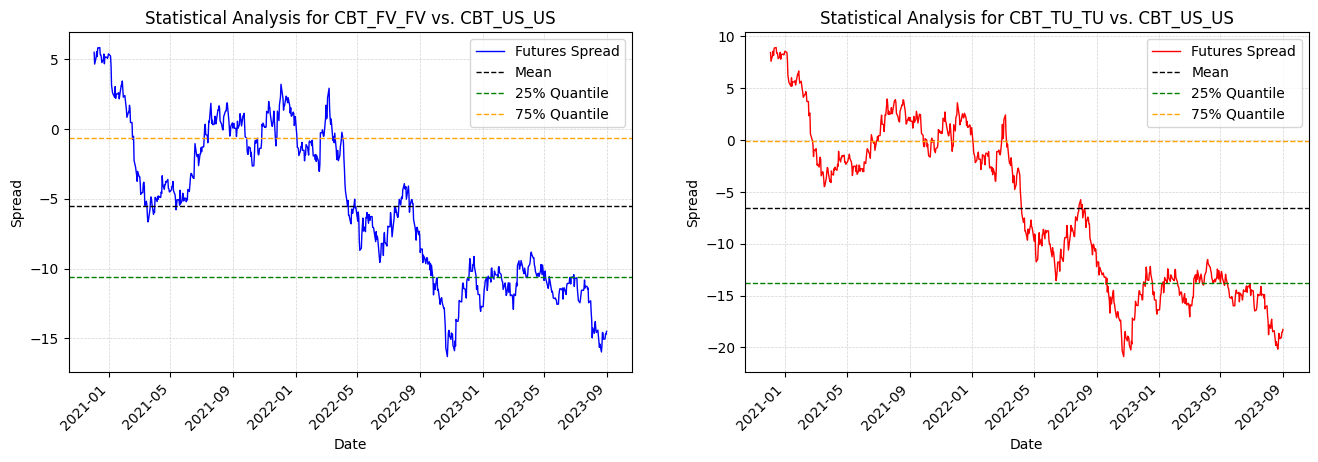

In [222]:
def plot_statistics(df1, df2, column_name, titles):
    """
    Plots the specified column of two DataFrames over time in subplots.

    Inputs:
        df1, df2 (pd.DataFrame): DataFrames containing the data to plot.
        column_name (str): Name of the column to plot.
        titles (tuple): Titles of the plots.
    """
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    # Plot for df1
    df1[column_name].plot(ax=axs[0], kind='line', color='blue', linewidth=1)
    axs[0].set_title(titles[0])
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Spread')
    axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
    axs[0].tick_params(axis='x', rotation=45)

    axs[0].axhline(y=s1_stats.loc[f'{W} vs. {X}', 'Mean'], color='black', linestyle='--', linewidth = 1 ,label='Mean')
    axs[0].axhline(y=s1_stats.loc[f'{W} vs. {X}', '25% Quantile'], color='green', linestyle='--', linewidth = 1, label='25% Quantile')
    axs[0].axhline(y=s1_stats.loc[f'{W} vs. {X}', '75% Quantile'], color='orange', linestyle='--', linewidth = 1, label='75% Quantile')
    axs[0].legend()

    # Plot for df2
    df2[column_name].plot(ax=axs[1], kind='line', color='red',linewidth=1)
    axs[1].set_title(titles[1])
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Spread')
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
    axs[1].tick_params(axis='x', rotation=45)

    axs[1].axhline(y=s2_stats.loc[f'{Y} vs. {Z}', 'Mean'], color='black', linestyle='--', linewidth = 1, label='Mean')
    axs[1].axhline(y=s2_stats.loc[f'{Y} vs. {Z}', '25% Quantile'], color='green', linestyle='--', linewidth = 1, label='25% Quantile')
    axs[1].axhline(y=s2_stats.loc[f'{Y} vs. {Z}', '75% Quantile'], color='orange', linestyle='--', linewidth = 1, label='75% Quantile')
    axs[1].legend()

    plt.show()

# Plot the spreads over time
plot_statistics(s1, s2, 'Futures Spread', (f'Statistical Analysis for {W} vs. {X}', f'Statistical Analysis for {Y} vs. {Z}'))


The provided graphs offer a detailed statistical analysis of the spreads for two pairs of futures contracts across a period stretching from early 2021 to late 2023.

In the first graph, the blue line tracks the day-to-day spread of the 5-Year Treasury Note Futures (CBT FV FV) against the 30-Year Treasury Bond Futures (CBT US US). Significant deviations from the mean line within this graph may indicate increased market activity or particular events that have influenced the bond market.

The second graph, colored in red, tracks the daily spread of the 2-Year Treasury Note Futures (CBT TU TU) compared to the 30-Year Treasury Bond Futures (CBT US US). Here, the fluctuations are more marked, suggesting greater volatility in this pair than in the first. Additionally, there is a noticeable downward trend in the spread over the observed period, echoing the pattern seen in the first pair.

Both graphs use central tendency lines—mean and quantiles to provide the levels of spreads. The mean line serves as a benchmark for average spread levels, while the quantile lines help to illustrate the distribution of spread values, encapsulating the range within which the majority of data points fall.

## 3.3. Volatility Analysis

In the Volatility Analysis section of our project, we will dive into the variability of the futures spreads over time. This analysis is crucial for understanding the degree of risk associated with the spreads, as it measures how much the spread's price fluctuates relative to its average price over a specified period.

The `calculate_historical_volatility` function is designed to determine the historical volatility of a particular financial instrument, represented by the standard deviation of its daily percentage price changes. Historical volatility is a widely used measure of risk in financial markets, indicating how much the price of an asset fluctuates over time.

Historical volatility provides insight into the past variability of price movements and is often annualized to represent an estimate of how much the price could deviate from its current level over a year.

In [223]:
def calculate_historical_volatility(df, column_name, index_name):
    """
    Calculate the historical volatility and return it in a DataFrame with a specified title.

    Inputs:
        df (pd.DataFrame): DataFrame containing the price data.
        column_name (str): Name of the column containing the prices.
        title (str): Title for the DataFrame index.

    Outputs:
        pd.DataFrame: DataFrame containing the historical volatility.
    """
    # Calculate the spread as percentage change
    daily_returns = df[column_name].pct_change()

    # Calculate the standard deviation of the spread(historical volatility)
    volatility = daily_returns.std()

    # Return the result in a DataFrame
    return pd.DataFrame({'Volatility': [volatility]}, index=[index_name])

# Calculate the historical volatility for s1 and s2
s1_historical_volatility = calculate_historical_volatility(s1, 'Futures Spread', f'{W} vs. {X}')
s2_historical_volatility = calculate_historical_volatility(s2, 'Futures Spread', f'{Y} vs. {Z}')
combination_volatility = pd.concat([s1_historical_volatility, s2_historical_volatility], axis=0)
combination_volatility


,Volatility
CBT_FV_FV vs. CBT_US_US,1.042362
CBT_TU_TU vs. CBT_US_US,10.463647


For the spread between the 5-Year Treasury Note Futures (CBT_FV_FV) and the 30-Year Treasury Bond Futures (CBT_US_US), the historical volatility is 1.042362. indicating that the spread's price movements have been relatively stable without experiencing very high price swings during the observed period.

In contrast, the spread between the 2-Year Treasury Note Futures (CBT_TU_TU) and the 30-Year Treasury Bond Futures (CBT_US_US) shows a historical volatility of 10.463, which is significantly higher. This implies that the spread experienced considerable price fluctuations, and thus, it carried a higher level of risk (unpredictable data).

In summary, the CBT_TU_TU vs. CBT_US_US spread was substantially more volatile than the CBT_FV_FV vs. CBT_US_US spread, suggesting that investors in the former might have faced a higher risk and potentially greater returns or losses due to the larger price movements.

The `analyze_spread_with_rolling_windows` function is designed to performs a comprehensive analysis on futures spread data using a range of specified rolling window sizes. It calculates the rolling average of the spread and the deviation of the spread from this rolling average for each window size. The function then plots two graphs for each rolling window: one showing the actual futures spread overlaid with its rolling average, and the other depicting the deviation from the rolling average over time.

In addition to plotting, the function computes and returns a DataFrame containing statistical measures for each rolling window, including the mean, standard deviation, minimum, maximum, and various quantiles of the deviation. These statistics offer a quantitative view of the spread's fluctuations around its rolling average.

By extending the window, we reduce the effect of daily price variations, which brings the longer-term trends and broader market movements into clearer view. Additionally, these larger windows can unveil seasonal patterns or cyclical behaviors that might be obscured by the day-to-day market fluctuations. Conversely, shorter windows are more sensitive to immediate market shifts, reacting quickly to daily events. This sensitivity can be advantageous for capturing the market's immediate responses. In contrast, the insights gained from examining the data through larger windows contribute to our understanding of the spread's long-term stability and overarching trends.

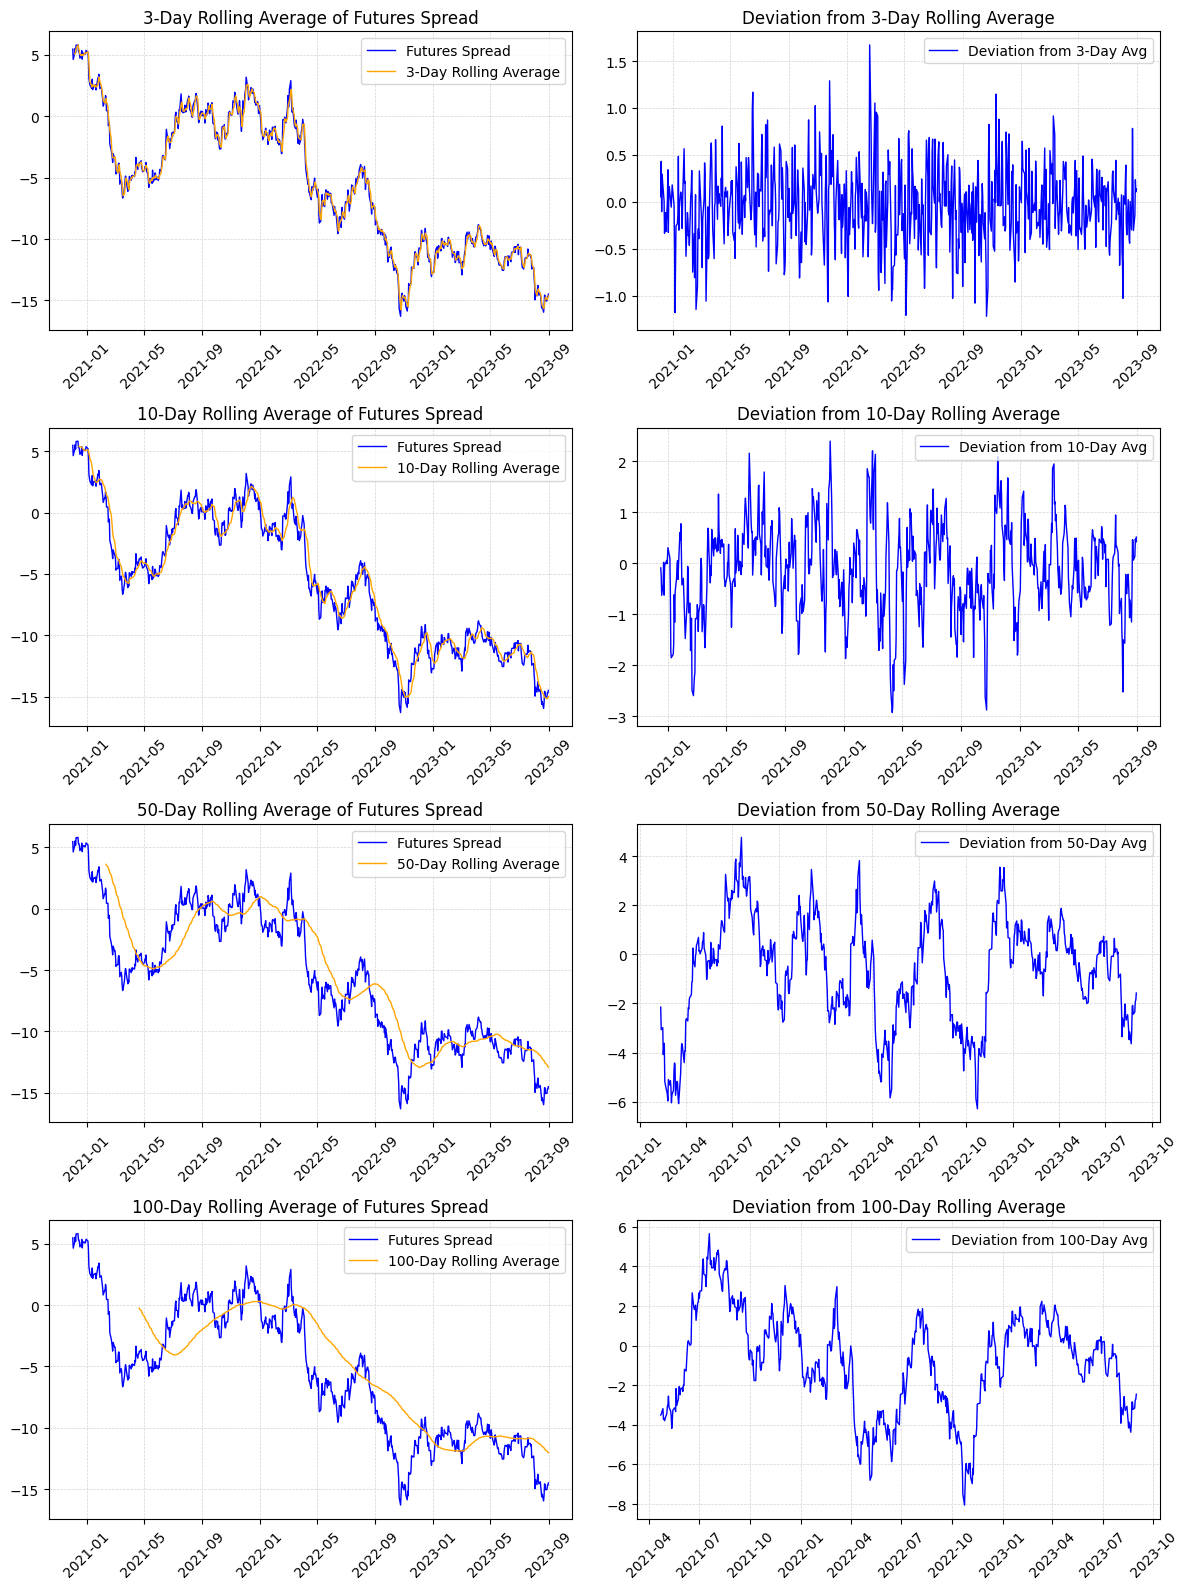

,Mean,Std_dev,Min,Max,1% Quantile,5% Quantile,25% Quantile,50% Quantile,75% Quantile,90% Quantile,95% Quantile,99% Quantile
Window_size,,,,,,,,,,,,
3,-0.027336,0.405408,-1.221297,1.671823,-1.054355,-0.698221,-0.281255,-0.022120,0.216807,0.467371,0.634193,0.949616
10,-0.129433,0.875327,-2.932141,2.393763,-2.504850,-1.658455,-0.662762,-0.096409,0.460658,0.929506,1.275338,1.851754
50,-0.615621,2.169575,-6.295552,4.771728,-5.811579,-4.423597,-2.067938,-0.281646,0.867183,2.104401,2.637876,3.558680
100,-0.826149,2.505838,-8.050985,5.653477,-6.533640,-4.985953,-2.556997,-0.655414,0.905128,2.108671,3.040116,4.465685


In [224]:
def analyze_spread_with_rolling_windows(df, rolling_windows):
    
    rows = []
    deviation_data = pd.DataFrame()

    # Creating the plots
    fig, axs = plt.subplots(len(rolling_windows), 2, figsize=(12, 4 * len(rolling_windows)))

    for i, window in enumerate(rolling_windows):
        # Compute rolling average
        df[f'{window}-Day Avg'] = df['Futures Spread'].rolling(window=window).mean()

        # Compute deviation from rolling average
        deviation = df['Futures Spread'] - df[f'{window}-Day Avg']

        # Calculating statistics
        row = {
            'Window_size': window,
            'Mean': np.mean(deviation),
            'Std_dev': np.std(deviation),
            'Min': deviation.min(),
            'Max': deviation.max()
        }

        # Calculating quantiles
        quantiles = deviation.quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
        for quantile, value in quantiles.items():
            percent_label = f'{int(quantile * 100)}% Quantile'
            row[percent_label] = value

        rows.append(row)

        # Plotting Spread with Rolling Average
        axs[i, 0].plot(df.index, df['Futures Spread'], label='Futures Spread', color='blue', linewidth=1)
        axs[i, 0].plot(df.index, df[f'{window}-Day Avg'], label=f'{window}-Day Rolling Average', color='orange', linewidth=1)
        axs[i, 0].set_title(f'{window}-Day Rolling Average of Futures Spread')
        axs[i, 0].tick_params(axis='x', rotation=45)
        axs[i, 0].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
        axs[i, 0].legend()

        # Plotting Deviation from Rolling Average
        axs[i, 1].plot(df.index, deviation, label=f'Deviation from {window}-Day Avg', color='blue', linewidth=1)
        axs[i, 1].set_title(f'Deviation from {window}-Day Rolling Average')
        axs[i, 1].tick_params(axis='x', rotation=45)
        axs[i, 1].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
        axs[i, 1].legend()

        deviation_data[f'{window}-Deviation'] = deviation

    plt.tight_layout()
    plt.show()


    # Return the statistics in a DataFrame
    stats_df = pd.DataFrame(rows)
    stats_df.set_index('Window_size', inplace=True)

    return stats_df, deviation_data

# Analyze the spread with different rolling windows
rolling_windows = [3, 10, 50, 100]
rolling_s1, deviation_data_s1 = analyze_spread_with_rolling_windows(s1, rolling_windows)
rolling_s1


The graphs presented illustrate the rolling averages and their deviations for the futures spread data across four different window sizes: 3-day, 10-day, 50-day, and 100-day.

On the left side of each pair of graphs, we see the actual futures spread traced in blue, accompanied by its rolling average in orange. As we look from the top graph down, the lines representing the rolling averages grow increasingly smoother, which indicates that the averaging process is muting the daily price swings and bringing longer-term trends into focus.

Turning to the right side, each graph measures the volatility of the spread by charting the deviation from the rolling average. The magnitude of these deviations indicates the level of volatility, with larger swings pointing to greater volatility. Notably, as the size of the rolling window expands, these deviations become more pronounced, suggesting that the spread's variability is more substantial over extended periods.

The accompanying statistical data adds depth to the graphed information. For instance, the mean deviation is minimal for the 3-day window, but it shifts more negatively with the enlargement of the window size. Similarly, the standard deviation grows with each increase in the window size, underscoring the fact that fluctuations from the rolling average are more marked over broader time frames. The quantiles, particularly the 1% and 99%, offer insights into the distribution of the deviations, especially the extremes, which inform us about potential tail risks.

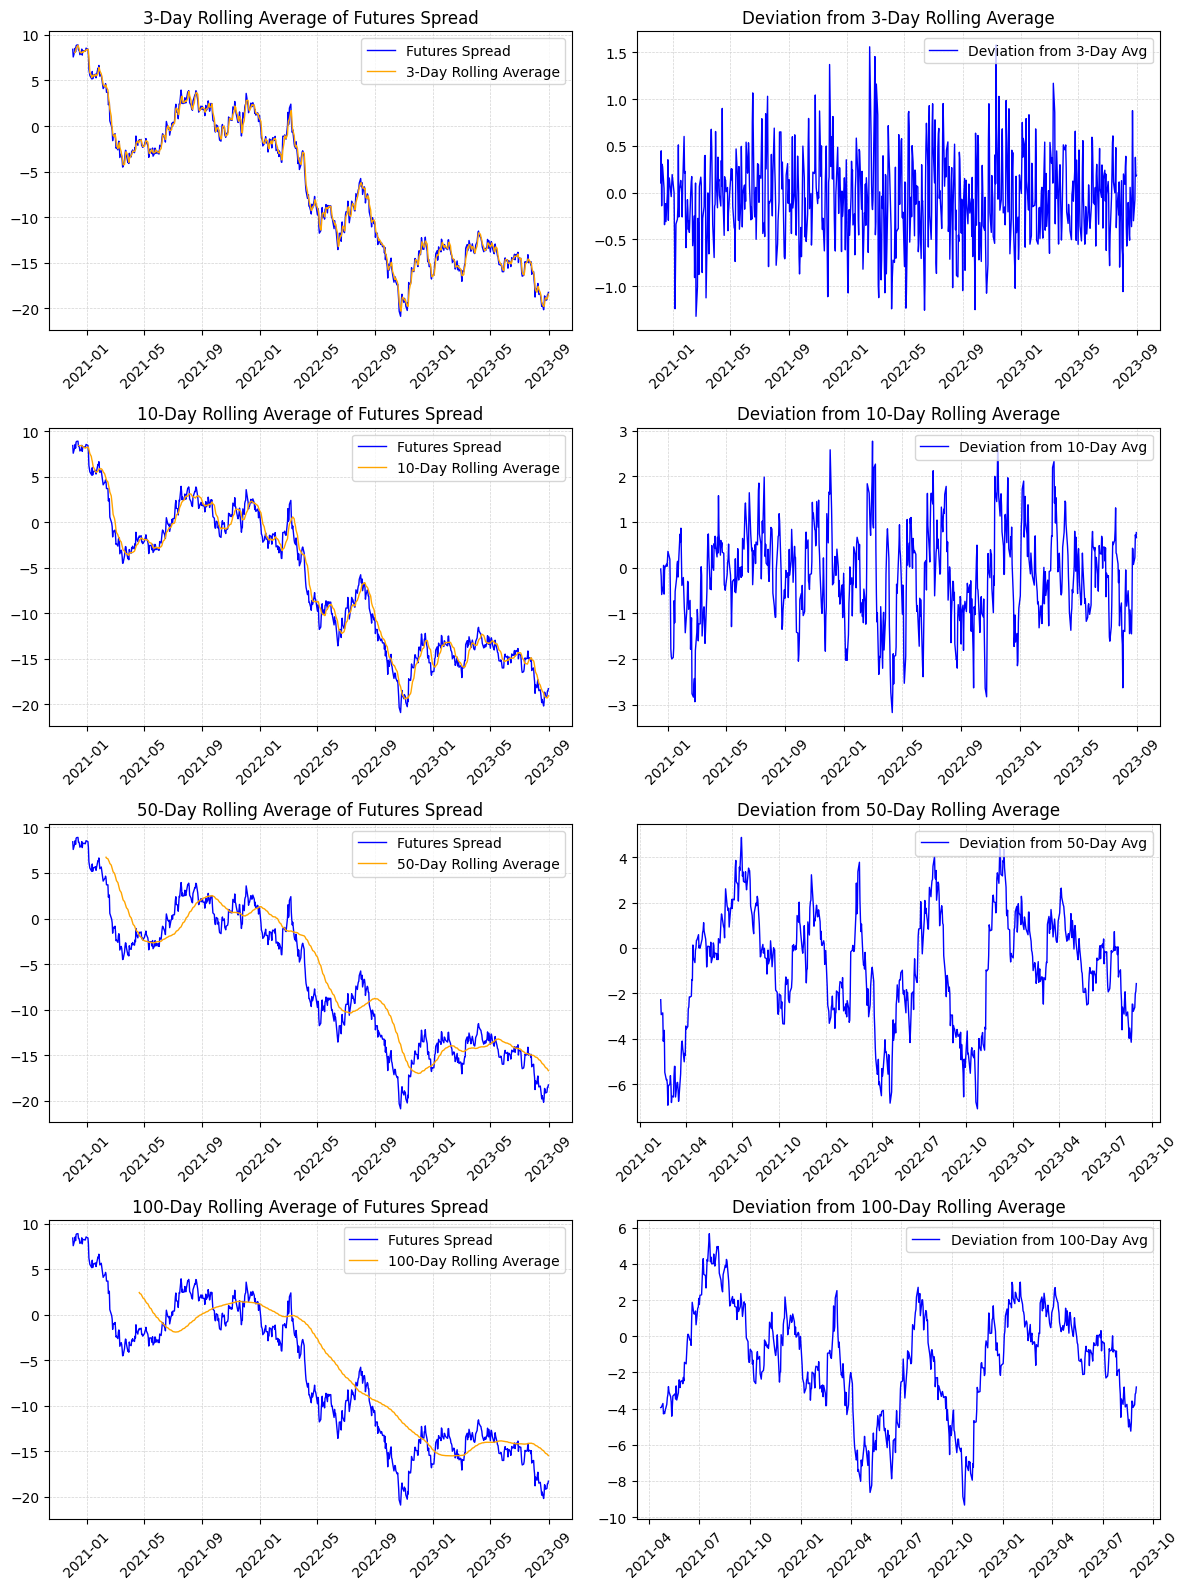

,Mean,Std_dev,Min,Max,1% Quantile,5% Quantile,25% Quantile,50% Quantile,75% Quantile,90% Quantile,95% Quantile,99% Quantile
Window_size,,,,,,,,,,,,
3,-0.036770,0.466079,-1.322922,1.580022,-1.121939,-0.816962,-0.338400,-0.049611,0.250967,0.542272,0.708867,1.042594
10,-0.173887,1.010719,-3.172559,2.769070,-2.637324,-1.935606,-0.834218,-0.148674,0.482319,1.089063,1.547594,2.136543
50,-0.872146,2.500989,-7.073606,4.863159,-6.554922,-5.532721,-2.522742,-0.473932,0.955401,2.094860,2.947014,3.842723
100,-1.318118,2.918909,-9.332499,5.667879,-8.013655,-6.792505,-3.159893,-0.933508,0.848983,2.088033,3.004942,4.517545


In [225]:
# Analyze the spread with different rolling windows
rolling_windows = [3, 10, 50, 100]
rolling_s2, deviation_data_s2 = analyze_spread_with_rolling_windows(s2, rolling_windows)
rolling_s2

The series of graphs of the second pair of futures demonstrate similar trends as the previous pair of futures over varying window sizes: 3-day, 10-day, 50-day, and 100-day.

In each of the left graphs, the actual futures spread is delineated in blue, with its rolling average depicted in orange. It can be noticed a trend towards smoother rolling average lines, indicating that as the window size increases where short-term price fluctuations are more effectively smoothed out. 

The right graph in each row indicated the volatility of the spread by plotting the deviations from the rolling average. These deviations are more expansive as the rolling window widens, implying that the spread's variability is more pronounced over more extended periods compared to shorter ones.

Moreover, the statistical data alongside the graphs reveals that the mean deviation starts off modestly for the 3-day window but becomes increasingly negative as we broaden the window size. Notably, for this particular futures spread, both the deviations and the rolling averages exhibit a broader range than those observed in the previous pair.

To sum up, these visualizations depict that the futures spread experience more significant fluctuations and a wider range of values over time, which indicate a higher risk.

## 3.4. Risk Metric Analysis

In the Risk Metrics Calculation section of our project, we focus on quantifying the potential risks associated with our futures spreads. The key risk metrics that we will focus on are Value at Risk (VaR) and Expected Shortfall (ES). 

The `calculate_var` function is designed to compute the Value at Risk (VaR) for a series of returns, which represents the maximum loss expected over a given time period with a certain confidence level. It's a statistical technique that uses the standard deviation of historical returns and a confidence level of 95% to estimate the potential loss.

The `calculate_es` function is a risk measure that, unlike VaR, takes into account the size of losses in the tail end of the distribution of possible returns. This function calculates ES for a series of returns, providing an average of the worst losses that exceed the VaR threshold, thus giving a sense of the expected loss on days when there's a significant downturn.

The `calculate_var_es` function is designed to aggregate the previous two calculations and applies them to a specific column within a DataFrame. 

Finally the code plots these risk metrics on the returns of the spreads, providing a visual representation of where the calculated VaR and ES levels fall in relation to the actual returns of each spread over time. This visual aid is useful for understanding the level of risk associated with the spread movements.

,VaR,ES
CBT_FV_FV vs. CBT_US_US,-1.714533,-5.2392
CBT_TU_TU vs. CBT_US_US,-17.211168,NaN


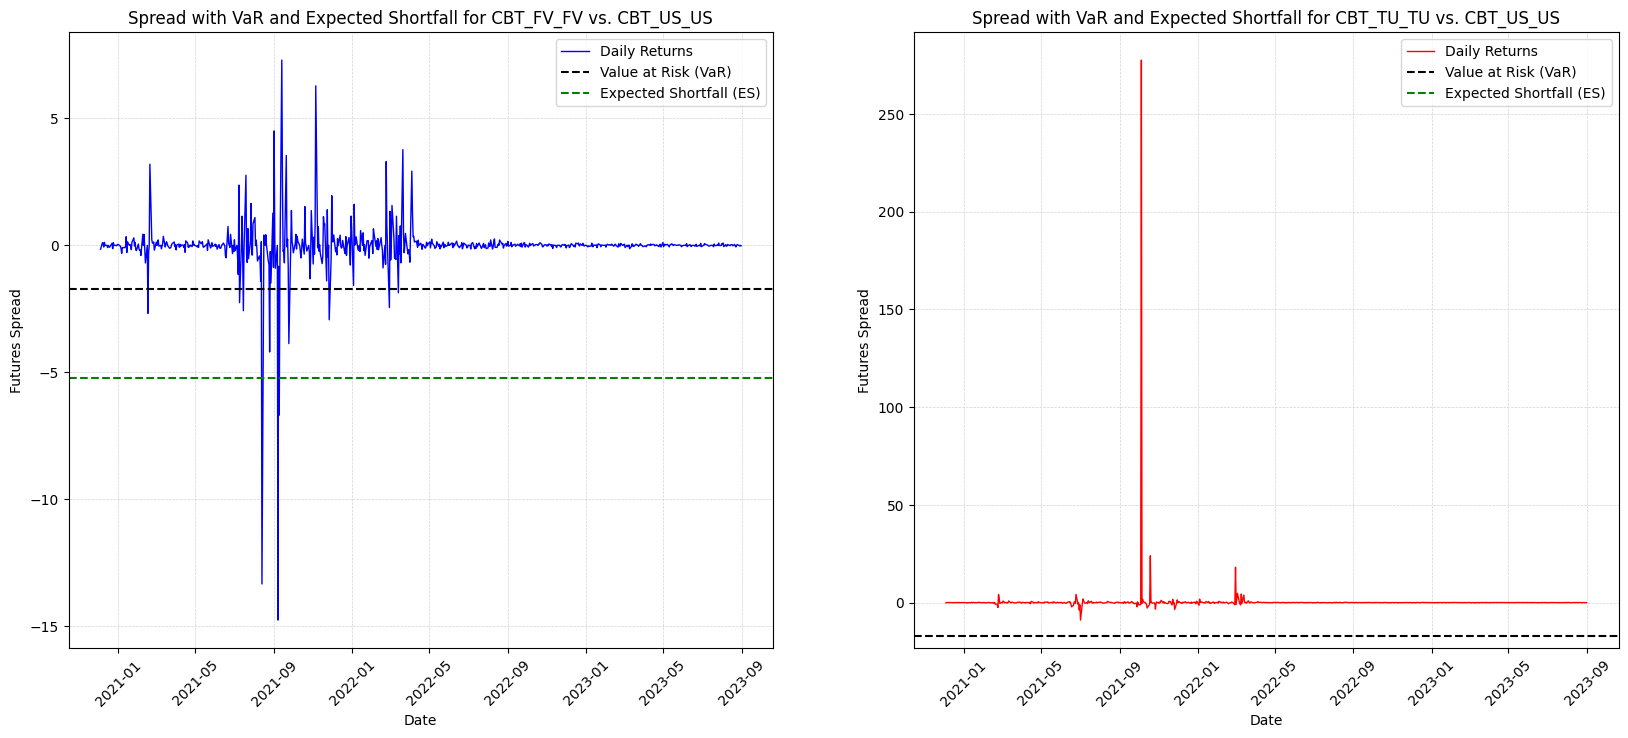

In [226]:
def calculate_var(returns, confidence_level=0.95):
    """
    Calculate the Value at Risk (VaR) at a given confidence level.

    Inputs:
        returns (pd.Series): Series containing the returns.
        confidence_level (float): Confidence level for VaR.

    Outputs:
        float: Value at Risk (VaR).
    """
    if len(returns.dropna()) < 2:
        return None
    mean_return = returns.mean()
    std_dev = returns.std()
    var = norm.ppf(1 - confidence_level) * std_dev
    return var

def calculate_es(returns, confidence_level=0.95):
    """
    Calculate the Expected Shortfall (ES) at a given confidence level.

    Inputs:
        returns (pd.Series): Series containing the returns.
        confidence_level (float): Confidence level for ES.
    Outputs:
        float: Expected Shortfall (ES).
    """
    if len(returns.dropna()) < 2:
        return None
    var = calculate_var(returns, confidence_level)
    es = returns[returns < var].mean()
    return es

def calculate_var_es(df, column_name, index_name, confidence_level=0.95):
    """
    Calculate Value at Risk (VaR) and Expected Shortfall (ES) for a given DataFrame.

    Inputs:
        df (pd.DataFrame): DataFrame containing the price data.
        column_name (str): Name of the column containing the prices.
        confidence_level (float): Confidence level for VaR and ES.

    Ouptuts:
        pd.DataFrame: DataFrame containing the VaR and ES.
    """
    # Calculate returns as percentage change
    returns = df[column_name].pct_change().dropna()

    # Calculate VaR and ES
    var = calculate_var(returns, confidence_level)
    es = calculate_es(returns, confidence_level)

    return pd.DataFrame({'VaR': [var], 'ES': [es]}, index=[index_name])

# Calculate VaR and ES for s1 and s2
s1_var_es= calculate_var_es(s1, 'Futures Spread', f'{W} vs. {X}')  
s2_var_es= calculate_var_es(s2, 'Futures Spread', f'{Y} vs. {Z}')
combination_var_es = pd.concat([s1_var_es, s2_var_es], axis=0)

# Plotting the results as subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# s1 plot
axs[0].plot(s1['Futures Spread'].pct_change(), label='Daily Returns', color='blue', linewidth=1)
axs[0].axhline(y=s1_var_es['VaR'][f'{W} vs. {X}'], color='black', linestyle='--', label='Value at Risk (VaR)')
axs[0].axhline(y=s1_var_es['ES'][f'{W} vs. {X}'], color='g', linestyle='--', label='Expected Shortfall (ES)')
axs[0].set_title(f'Spread with VaR and Expected Shortfall for {W} vs. {X}')
axs[0].set_xlabel('Date')
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_ylabel('Futures Spread')
axs[0].legend()
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

# s1 plot
axs[1].plot(s2['Futures Spread'].pct_change(), label='Daily Returns', color='red', linewidth=1)
axs[1].axhline(y=s2_var_es['VaR'][f'{Y} vs. {Z}'], color='black', linestyle='--', label='Value at Risk (VaR)')
axs[1].axhline(y=s2_var_es['ES'][f'{Y} vs. {Z}'], color='g', linestyle='--', label='Expected Shortfall (ES)')
axs[1].set_title(f'Spread with VaR and Expected Shortfall for {Y} vs. {Z}')
axs[1].set_xlabel('Date')
axs[1].tick_params(axis='x', rotation=45)
axs[1].set_ylabel('Futures Spread')
axs[1].legend()
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')


combination_var_es


Both graphs present the Value at Risk (VaR) and Expected Shortfall (ES) for the futures spreads between two pairs of Treasury futures. 

The left graph displays the daily returns of the spread in blue, which are notably concentrated in the latter half of 2021 and the early months of the subsequent year, before stabilizing around a zero mark indicating low volatility. The dashed black line marks the VaR at -1.714533, suggesting the maximum expected loss at the chosen confidence level, while the dashed green line illustrates the ES at -5.2392, averaging out the losses beyond the VaR threshold to reflect the expected loss on days with the most severe declines.

The right graph, delineated in red, captures the daily returns for the second spread, with a pronounced spike in October 2021, coinciding with the Federal Reserve's announcement of aggressive interest rate hikes aimed at controlling inflation. Here, the VaR is much lower at -17.211168, implying a greater potential loss and thus a higher risk, as evidenced by the increased volatility. The absence of an ES calculation may be due to an insufficient number of instances where losses surpass the VaR.

In summary, the second pair, CBT_TU_TU vs. CBT_US_US, appears to carry a higher risk profile, as suggested by the more significant potential loss indicated by the VaR and the inability to calculate an ES, which emphasizes the potential for extreme spread behavior. 

## 3.5. Technical Analysis

In the Technical Analysis phase of our project, we focus on understanding the Relative Strength Index (RSI) and Moving Average Convergence Divergence (MACD) to understand the momentum and trend strength of our futures spreads. By analyzing RSI, we assess whether the spreads are overbought or oversold, which can indicate potential reversals and the MACD helps us discern the direction and durability of the trend over time. 

The `calculate_rsi` function is designed to calculate the Relative Strength Index (RSI), a momentum indicator that oscillates between 0 and 100 and provides the speed and change of price movements. Traditionally, an RSI above 70 is considered overbought, indicating a potential sell-off, while an RSI below 30 is seen as oversold, indicating a potential price increase.

The `calculate_macd` function is designed to compute the Moving Average Convergence Divergence (MACD), a trend-following momentum indicator. It is obtained by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA. The MACD's nine-day EMA, known as the "signal line," is plotted alongside the MACD line and may act as a trigger for buy or sell signals.

Upon calculating both RSI and MACD, the code creates a series of subplots arranged in two columns, each dedicated to one of the datasets. These visualizations allow for a comparative analysis of momentum and trend indicators across the different futures spreads.

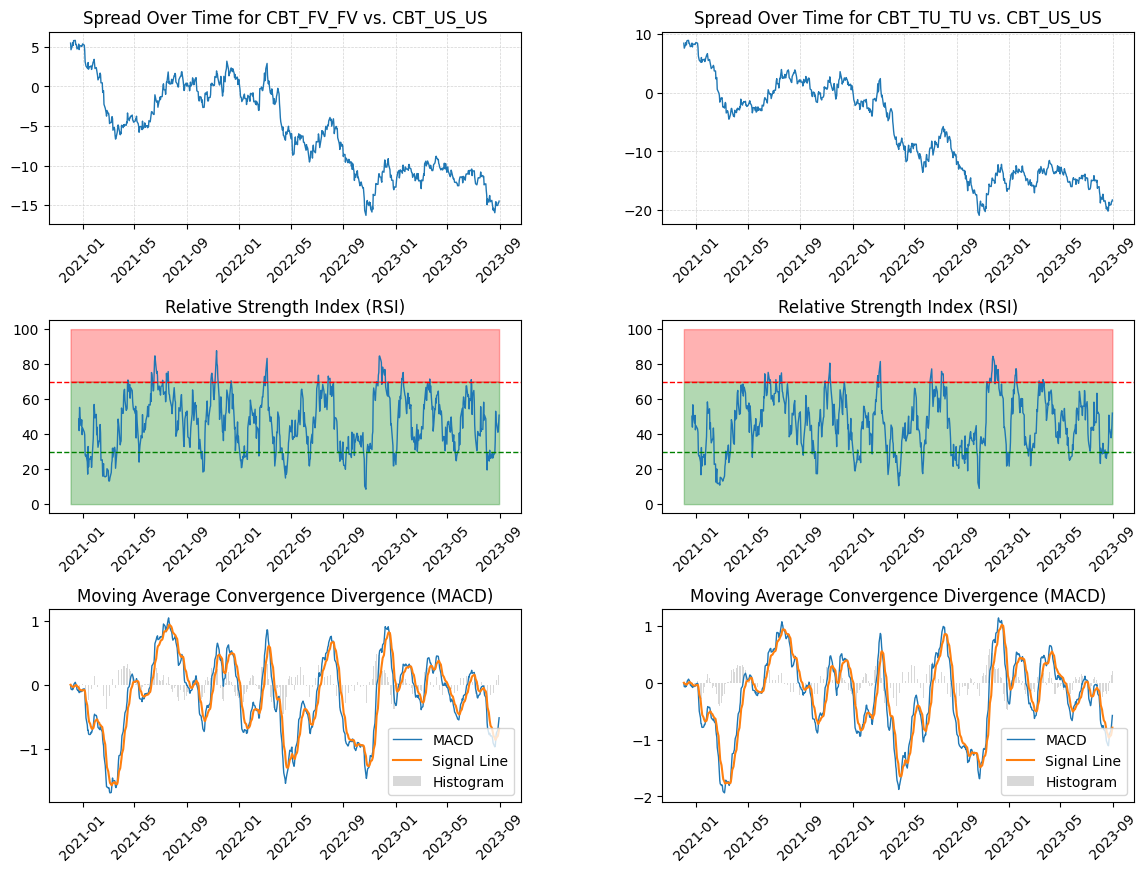

In [227]:
# Define RSI calculation
def calculate_rsi(data, window):
    delta = data.diff()
    gain = ((delta + delta.abs()) / 2).fillna(0)
    loss = ((-delta + delta.abs()) / 2).fillna(0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Define MACD calculation
def calculate_macd(data, slow, fast, signal):
    exp1 = data.ewm(span=fast, adjust=False).mean()
    exp2 = data.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line


# Parameters for RSI and MACD
rsi_window = 14  #  RSI period
macd_slow = 26  #  MACD slow period
macd_fast = 12  #  MACD fast period
macd_signal = 9  #  MACD signal period

# Calculate RSI
s1['RSI'] = calculate_rsi(s1['Futures Spread'], rsi_window)
s2['RSI'] = calculate_rsi(s2['Futures Spread'], rsi_window)

# Calculate MACD
s1['MACD'], s1['Signal_Line'] = calculate_macd(s1['Futures Spread'], macd_slow, macd_fast, macd_signal)
s2['MACD'], s2['Signal_Line'] = calculate_macd(s2['Futures Spread'], macd_slow, macd_fast, macd_signal)

fig = plt.figure(figsize=(14, 10)) 
gs = gridspec.GridSpec(3, 2, figure=fig)

# First subplot
ax0 = plt.subplot(gs[0, 0])
ax0.plot(s1['Futures Spread'], linewidth=1)
ax0.set_title(f'Spread Over Time for {W} vs. {X}')
ax0.tick_params(axis='x', rotation=45)
ax0.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

# Second subplot
ax1 = plt.subplot(gs[1,0], sharex=ax0)
ax1.plot(s1['RSI'], label='RSI', linewidth=1)
ax1.axhline(70, color='r', linestyle='--', linewidth=1)
ax1.axhline(30, color='g', linestyle='--', linewidth=1)
ax1.tick_params(axis='x', rotation=45)
ax1.fill_between(s1.index, 0, 70, alpha=0.3, color='green', label='Oversold Region (<30)')
ax1.fill_between(s1.index, 70, 100, alpha=0.3, color='red', label='Overbought Region (>70)')
ax1.set_title('Relative Strength Index (RSI)')

# Third subplot
ax2 = plt.subplot(gs[2, 0],sharex=ax0)
ax2.plot(s1['MACD'], label='MACD', linewidth=1)
ax2.plot(s1['Signal_Line'], label='Signal Line')
ax2.tick_params(axis='x', rotation=45)
ax2.bar(s1.index, s1['MACD'] - s1['Signal_Line'], label='Histogram', color='grey', alpha=0.3)
ax2.set_title('Moving Average Convergence Divergence (MACD)')

plt.legend()

# Fourth subplot
ax3 = plt.subplot(gs[0, 1])
ax3.plot(s2['Futures Spread'], linewidth=1)
ax3.set_title(f'Spread Over Time for {Y} vs. {Z}')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

# Fifth subplot
ax4 = plt.subplot(gs[1,1], sharex=ax3)
ax4.plot(s2['RSI'], label='RSI', linewidth=1)
ax4.tick_params(axis='x', rotation=45)
ax4.axhline(70, color='r', linestyle='--', linewidth=1)
ax4.axhline(30, color='g', linestyle='--', linewidth=1)
ax4.fill_between(s2.index, 0, 70, alpha=0.3, color='green', label='Oversold Region (<30)')
ax4.fill_between(s2.index, 70, 100, alpha=0.3, color='red', label='Overbought Region (>70)')
ax4.set_title('Relative Strength Index (RSI)')

# Sixth subplot
ax5 = plt.subplot(gs[2, 1],sharex=ax3)
ax5.plot(s2['MACD'], label='MACD', linewidth=1)
ax5.tick_params(axis='x', rotation=45)
ax5.plot(s2['Signal_Line'], label='Signal Line')
ax5.bar(s2.index, s2['MACD'] - s2['Signal_Line'], label='Histogram', color='grey', alpha=0.3)
ax5.set_title('Moving Average Convergence Divergence (MACD)')


# Adjust subplot spacing
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust these values as needed

# Show plot
plt.legend()
plt.show()


The displayed plots provide a view of the technical aspects of futures spread trading, covering the time-series spread data, the Relative Strength Index (RSI), and the Moving Average Convergence Divergence (MACD).

The spread over time for both futures pairs, CBT_FV_FV vs. CBT_US_US and CBT_TU_TU vs. CBT_US_US, shows a downtrend throughout the observed timeframe. This indicates that the price of CBT_FV_FV and CBT_TU_TU are greater with respect to CBT_US_US. 

The RSI tracks the velocity and magnitude of directional price movements. The areas above 70 and below 30, highlighted in the plots, signal overbought and oversold conditions, respectively. The plots suggest that both spreads frequently enter the oversold territory, hinting at potential buying opportunities with expectations of an upward reversal more so than overbought conditions, which would suggest selling opportunities.

The MACD plots feature a blue line that represents the difference between the short-term and long-term EMAs of the spreads, with an orange signal line that is the EMA of the MACD. The histograms indicate the momentum of the spread. Positive bars suggest an upward trend, whereas negative bars indicate a downward trend. The fluctuations shown in these plots reveal periods of varying momentum, with no clear sustained direction of movement for either spread.

Overall, these indicators combined suggest a market with alternating periods of buying and selling pressure, with the potential for trend reversals, particularly highlighted by the frequent oversold conditions as shown by the RSI. The MACD further corroborates this by showing short-term momentum shifts within the overarching downtrend observed in the spread data.

# 4. Comparative Analysis

In the Comparative Analysis section of our project, we focus on understanding a side-by-side examination of the two futures spreads, CBT_FV_FV vs. CBT_US_US and CBT_TU_TU vs. CBT_US_US.  The objective of this part is to find similarities and differences in their behaviors and responses to market forces. 

## 4.1. Frequency Analysis

The `check_cointegration` function is designed to test whether two time series are cointegrated. Cointegration indicates a long-term equilibrium relationship between two or more time series despite any short-term deviations. If two series are cointegrated, it implies that they move together over time and any deviations between them are temporary and will revert to a mean.

In essence, this function is useful for financial time series analysis for pairs trading strategies, where identifying cointegrated assets is crucial for determining pairs that will behave in a predictable manner over the long term.

In [228]:
def check_cointegration(df1, df2, column_name='Futures Spreads'):
    """
    Check if two series are cointegrated.

    Inputs:
        df1, df2 (pandas.DataFrame): DataFrames containing the futures prices.
        column_name (str): The name of the column containing the futures prices.

    Outputs:
        tuple: cointegration test statistic, p-value, and critical values.
    """
    series1 = df1[column_name]
    series2 = df2[column_name]

    # Perform cointegration test
    coint_test = ts.coint(series1, series2)

    return coint_test

# Example usage
cointegration_result = check_cointegration(s1, s2, 'Futures Spread')

# Display the results
test_statistic, p_value, critical_values = cointegration_result
print(f"Cointegration Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Critical Values: {critical_values}")

# Interpretation
if p_value < 0.05:
    print("The series are likely cointegrated, indicating a long-term equilibrium relationship.")
else:
    print("No evidence of cointegration found.")



Cointegration Test Statistic: -2.064079026416959
P-value: 0.4951501364880547
Critical Values: [-3.91184456 -3.34470095 -3.05039539]
No evidence of cointegration found.


The results of the cointegration test indicate that there is no statistically significant evidence of a cointegrating relationship between the two time series tested.

The value of -2.064079026416959 is higher than the critical values at common significance levels (1%, 5%, and 10%). To reject the null hypothesis of no cointegration, the test statistic would need to be lower (more negative) than at least one of the critical values.

The p-value of 0.4951501364880547 is well above 0.05, which is the conventional threshold for statistical significance. A p-value higher than 0.05 suggests that there is a high probability that any correlation found between the time series could be due to random chance rather than a genuine cointegrating relationship.

In summary, there is no evidence of cointegration found, meaning that based on the data and the cointegration test performed, the two time series do not appear to have a stable, long-term equilibrium relationship. 


## Correlation Matrix

The following code facilitates the comparative analysis through both a visual time-series comparison and a statistical correlation study of two futures spreads.

Initially, the code aligns the 'Futures Spread' data from `s1` and `s2` into a unified DataFrame named `aligned_spreads`. This alignment allows for a side-by-side comparison of the spreads' behavior. Next, the function computes the Pearson correlation coefficient for the spreads from the two futures pairs. This coefficient measures the extent to which the spreads move in tandem, with a value of +1 indicating perfect positive correlation, -1 a perfect negative correlation, and 0 no correlation at all.

Finally, the code creates two subplots. The first subplot plots the aligned spreads over time, providing a visual representation of their movements. The second subplot is a heatmap that graphically displays the correlation matrix, making it easy to discern the relationship between the spreads at a glance. 

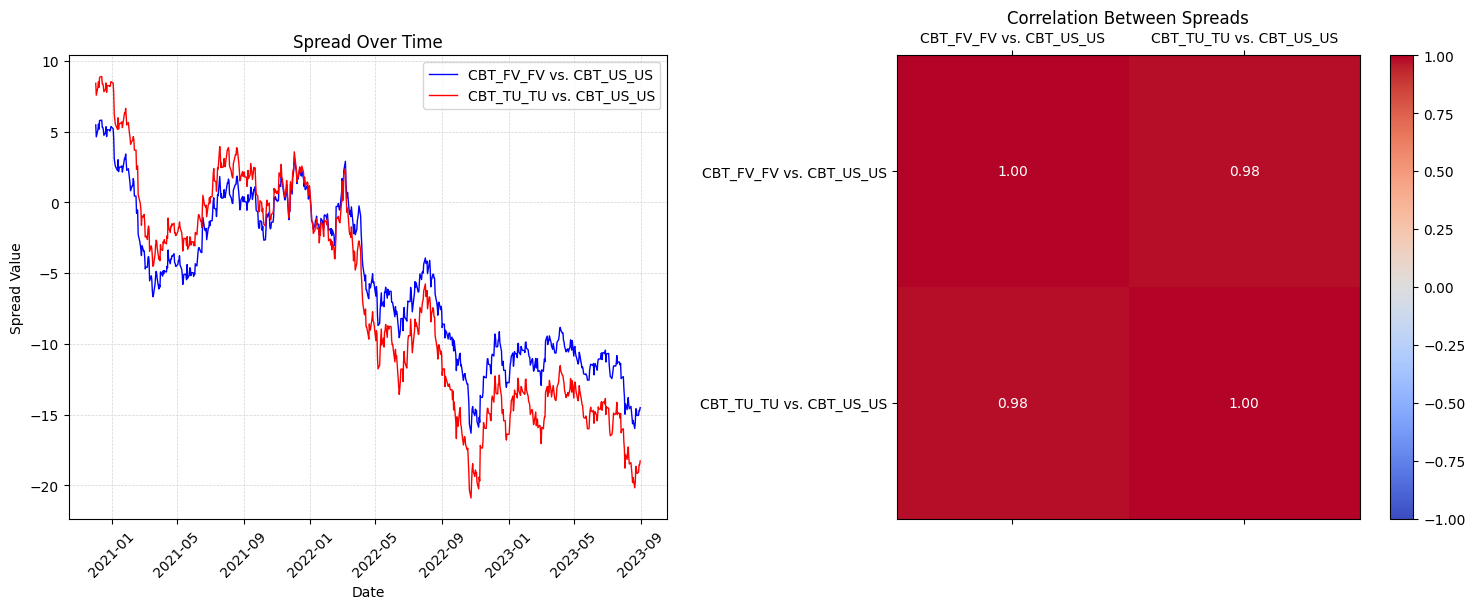

In [229]:
# Aligning spreads
aligned_spreads = pd.concat([s1['Futures Spread'], s2['Futures Spread']], axis=1)
aligned_spreads.columns = [f'{W} vs. {X}', f'{Y} vs. {Z}']

# Calculating correlation
correlation = aligned_spreads.corr()

# Creating plots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: Spread Over Time
axs[0].plot(s1.index, s1['Futures Spread'], label=f'{W} vs. {X}', color='blue', linewidth=1)
axs[0].plot(s2.index, s2['Futures Spread'], label=f'{Y} vs. {Z}', color='red', linewidth=1)
axs[0].set_title('Spread Over Time')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Spread Value')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
axs[0].legend()

# Second subplot: Correlation Heatmap with annotated values using Matplotlib
cax = axs[1].matshow(correlation, cmap='coolwarm', norm=Normalize(vmin=-1, vmax=1))
fig.colorbar(cax, ax=axs[1])

# Annotating the correlation values
for (i, j), val in np.ndenumerate(correlation.values):
    axs[1].text(j, i, f'{val:.2f}', ha='center', va='center', color='white' if abs(val) > 0.5 else 'black')

axs[1].set_xticks(range(len(correlation.columns)))
axs[1].set_yticks(range(len(correlation.columns)))
axs[1].set_xticklabels(correlation.columns)
axs[1].set_yticklabels(correlation.index)
axs[1].set_title('Correlation Between Spreads')

plt.tight_layout()
plt.show()

In [62]:
# Display the correlation matrix
correlation

,CBT_FV_FV vs. CBT_US_US,CBT_TU_TU vs. CBT_US_US
CBT_FV_FV vs. CBT_US_US,1.000000,0.983187
CBT_TU_TU vs. CBT_US_US,0.983187,1.000000


The first plot displays the time series of futures spreads for two different Treasury futures pairs. It allows for a comparative observation of how each spread evolves over time. From the plot, we can deduce that the second pair (depicted in red, representing CBT_TU_TU vs. CBT_US_US) initially exhibits a higher positive spread, but by the end of 2021, it transitions to a more negative spread compared to the first pair (shown in blue, representing CBT_FV_FV vs. CBT_US_US). This indicates that the second pair experiences more significant price fluctuations than the first.

The heatmap on the right side of the image visualizes the correlation between these two spreads. The deep red color and the value of 0.983187 illustrate a very high degree of correlation, suggesting that the spreads tend to move together closely.

In summary, the plot and heatmap together reveal a strong synchronization in the movements of the two spreads, indicating little diversification benefit between the pairs. The high correlation suggests that similar market factors are influencing both pairs, and strategies involving these two spreads would have similar risk profiles due to their closely tied behaviors.

## Deviations Correlation Matrix

The `plot_deviation_correlation_heatmap` function is designed to illustrate the relationships (correlation) between deviations of different datasets, offering insights into how these deviations move in relation to each other. These deviations are calculated as the difference between the actual futures spread and its rolling average. The function begins by merging the deviation data into a single DataFrame. It then computes the Pearson correlation matrix for these merged deviations, which quantifies the linear relationships between each pair of deviations.

The axes of the heatmap are labeled with the names of the deviation datasets, rotated on the x-axis for readability. A color bar is also included to guide the interpretation of the color intensities in relation to the correlation values.

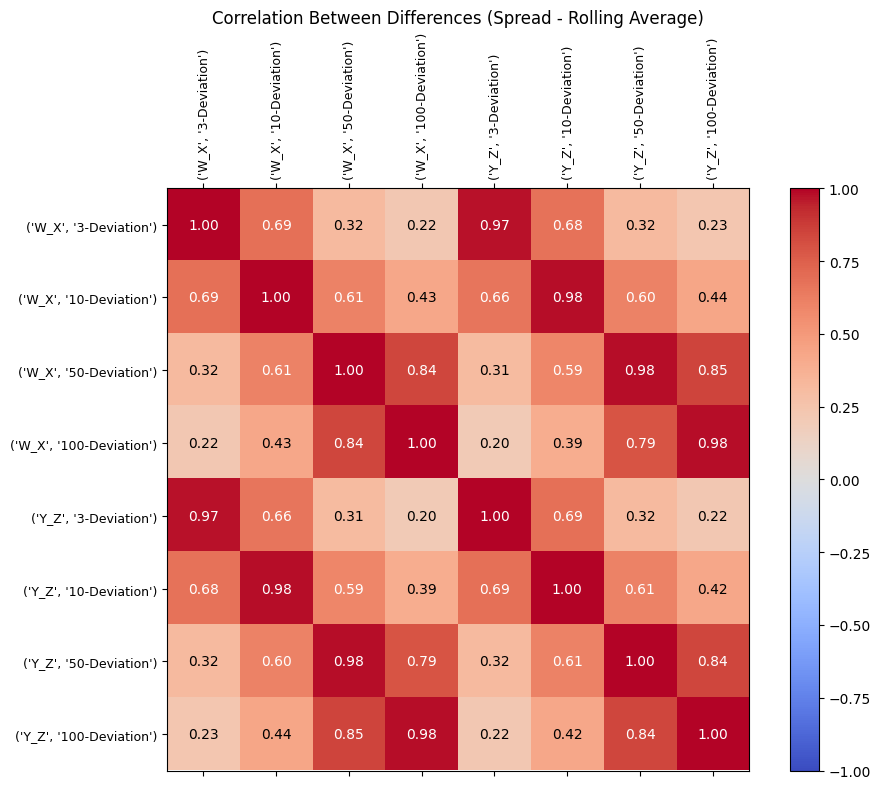

In [230]:
def plot_deviation_correlation_heatmap(*deviation_dfs, suffixes=None):
    """
    Plots a heatmap showing the correlation between the deviations (spread - rolling average)
    of different datasets using Matplotlib.

    Inputs:
        *deviation_dfs: Variable number of DataFrame objects containing deviation data.
        suffixes (tuple of str, optional): Suffixes to apply to columns of the merged DataFrame.
                                          Should be provided when the DataFrames have columns with the same name.

    Outputs:
        None
    """
    # Merging deviation data
    if suffixes is None:
        suffixes = [f'_{i}' for i in range(len(deviation_dfs))]
    deviation_data = pd.concat(deviation_dfs, axis=1, keys=suffixes)

    # Calculate correlation
    correlation_matrix = deviation_data.corr()

    # Plotting the heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(correlation_matrix, cmap='coolwarm', norm=Normalize(vmin=-1, vmax=1))
    fig.colorbar(cax)

    # Adding annotations
    for (i, j), val in np.ndenumerate(correlation_matrix.values):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', 
                color='white' if abs(val) > 0.5 else 'black')

    # Setting axis labels
    ax.set_xticks(range(len(correlation_matrix.columns)))
    ax.set_xticklabels(correlation_matrix.columns, rotation=90, va = 'bottom', fontsize=9)

    ax.set_yticks(range(len(correlation_matrix.index)))
    ax.set_yticklabels(correlation_matrix.index, fontsize=9)

    # Title and tight layout
    ax.set_title('Correlation Between Differences (Spread - Rolling Average)')
    plt.tight_layout()
    plt.show()


plot_deviation_correlation_heatmap(deviation_data_s1, deviation_data_s2, suffixes=('W_X', 'Y_Z'))

The correlation matrix provided contains correlation coefficients between the deviations from the rolling average for various window sizes (3, 10, 50, 100 days) for two futures spreads.

Within each spread there's a generally strong correlation between shorter and longer rolling window deviations, with coefficients ranging from moderate to very high (values from 0.19 to 0.98). This indicates that the deviations tend to move in the same direction to some extent. However, as the window size increases, the correlation within the same spread tends to decrease (though still remains positive). This might imply that short-term market forces and events have a different impact compared to long-term trends.

The strongest correlations between both pairs is observed at the 50-window period, which suggests that long-term deviations from the rolling average are more consistent with each other.

Comparing across spreads ('W_X' vs. 'Y_Z'), there is a very high correlation between similar window sizes, that suggest that the spreads are affected by similar factors or market conditions in the short term, leading to parallel movements in their deviations from the rolling average. Correlation coefficients between different window sizes across the two spreads show a varying degree of correlation, with some having high correlation and others much lower. 

In summary, the matrix indicates that both spreads exhibit similar behaviors in response to market dynamics, particularly in the short term.

## Cross-Correlation

The `plot_cross_correlation` function is designed to examine the dynamic relationship between two time series by assessing their cross-correlation across a series of time shifts or lags. The purpose is to uncover potential lead-lag relationships, which can suggest predictive patterns or influences one series may have on the other. 

The function starts by calculating the percentage change, commonly referred to as the daily returns, for the 'Futures Spread' column of both input dataframes, `df1` and `df2`. It then systematically shifts `df2` forward and backward in time relative to `df1`, computing the correlation coefficient for each shift to ascertain the strength and direction of their relationship at various lags.

The resulting plot depicts the variation of the correlation coefficient as the lag changes. Peaks in this plot may highlight instances where one time series is a leading indicator or is lagging behind the other, providing insights that can be instrumental for temporal analysis or for formulating trading strategies based on historical patterns.

In summary, this function and its resulting plot serve as analytical tools for investigating the temporal interdependencies between two financial time series, which is crucial for understanding market dynamics and making informed investment decisions.

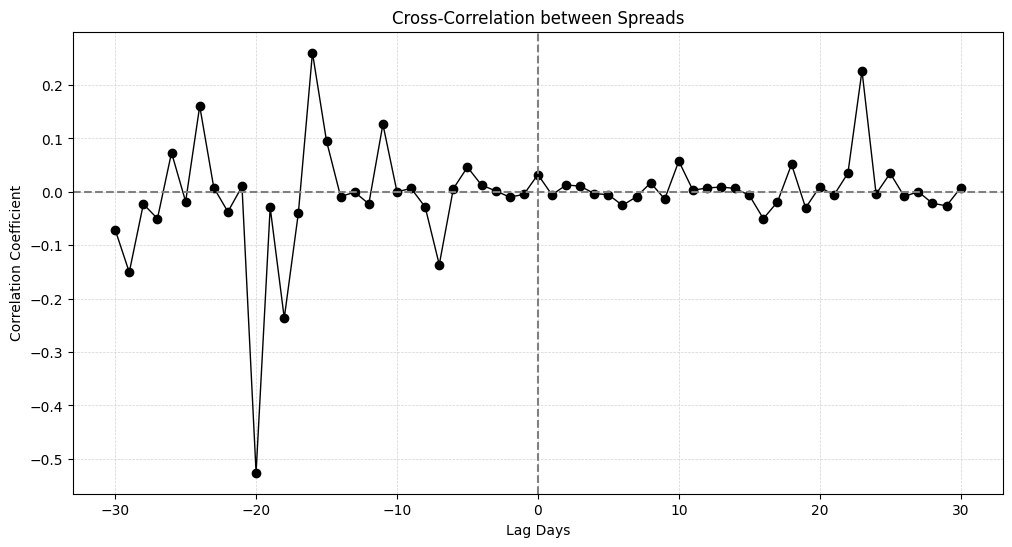

In [231]:
def plot_cross_correlation(df1, df2, column_name, lag_range):
    """
    Plots the cross-correlation between two time series with a specified range of lags.

    Inputs:
        series1 (pd.Series): First time series of daily returns.
        series2 (pd.Series): Second time series of daily returns.
        lag_range (range): Range of lags to calculate the cross-correlation for.

    """
    # Calculate daily returns
    daily_returns1 = df1[column_name].pct_change()
    daily_returns2 = df2[column_name].pct_change()

    # Calculate cross-correlation for each lag
    cross_correlation = [daily_returns1.corr(daily_returns2.shift(lag)) for lag in lag_range]

    # Plotting the cross-correlation
    plt.figure(figsize=(12, 6))
    plt.plot(lag_range, cross_correlation, marker='o', linestyle='-', linewidth = 1 ,color='black')
    plt.title('Cross-Correlation between Spreads')
    plt.xlabel('Lag Days')
    plt.ylabel('Correlation Coefficient')
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axvline(x=0, linestyle='--', color='gray')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
    plt.show()


plot_cross_correlation(s1, s2, 'Futures Spread', range(-30, 31))


The cross-correlation measures how well two series are related to each other at different time lags.

The coefficients vary widely, from as low as approximately -0.53 to as high as approximately +0.23. A positive value indicates that as one series moves up, the other series also tends to move up. Conversely, a negative value indicates an inverse relationship, where one series tends to move in the opposite direction of the other after the lag period.

The cross-correlation coefficients at negative lags indicates how past values of the second series relate to current values of the first series, a significant positive or negative coefficient at a negative lag, it implies that the second series might be leading the first series. Whereas for positive lags, the coefficients indicate how the current values of the second series relate to past values of the first series.

The most notable values are the high positive correlation (approx. +0.23) at lag -14 and the high negative correlation (approx. -0.53) at lag 10. This means that changes in the second series could potentially predict changes in the first series two weeks in advance, and vice versa, the first series might show similar changes 10 days after the second series.

In conclusion, while there are a few lags where the correlation is notably higher or lower than at other lags, the list as a whole does not provide a clear, consistent indication of a strong lead-lag relationship between the two time series.